# **CSCI 550 Assignment 1**
Derek Logan, Justin Mau, Gak Roppongi





---

# Executive Summary


  Given our dataset of customer data, we believe we were able to develop useful models for predicting whether or not a customer will or will not churn. First, we attempted to predict it using only one highly correlated predictor: "customer service calls." Since poor customer service seems a good reason for a customer to churn, we looked into that predictor first and found that it was highly correlated with churn. We then used a simple linear regression model on that predictor, but found that this model would not at all be useful. The model fit the data very poorly, and so we decided to try other, more complex models. 
  <br> <br>
  Our next model we generated was a Logistic Regression Model. This type of model is useful for predicting whether or not an event will occur, in this case, churn. For predictors that were split between day, evening, and night, we combined them into one, total predictor. We created dummy predictors in order to better process qualitative predictors, such as 'voicemail plan' or 'international plan'. We also removed irrelevant and useless predictors, such as phone number and area code. With our data properly processed, we could then generate our Logistic Regression Model. Besides the basic Logistic Regression model, we also tried 3 different methods to improve our model. First we tried tuning two hyperparameters associated with the logistic regression model (penalty and C) which resulted in marginal improvement. Second we investigated feature selection and looked at two methods (selectKbest, RFE) to choose the top 3 predictors and still saw marginal improvements. Lastly, we addressed the inbalance we have in our data by testing class weights and looking at the associated F1 score. Assigning the class weights appropriately increased our model accuracy to 83% from 76% seen previously. Further investigation could be conducted by testing combinations of class weights, hyperparameters, and features selection to see if further improvements could be made. 
<br><br>
  Our last model we developed was a Naive Bayes Model. This model makes the strong assumption that the predictors are independent, which is typically not the case. However, a Naive Bayes Model can still be useful to classify a customer as one who will churn or not. As for the set up of the test, we split the data set into two: the test and the training data set. The test data set contains 30% of all instances, and the training data set contains the rest 70% of the instances. Each data set contains the same ratio of response classes. We also removed the useless predictors that were removed in the logistic regression model. There was no hyperparameters needing to tune in this algorithm. This algorithm predicts the response value given the attribute values for each instance. The algorithm correctly predicted all the responses for all the instances from the test set. The performance was evaluated by comparing the prediction and the actual response of the instance. However, this is not because the algorithm is the best. Rather, the model fitted well for this particular data set becasue attributes were independent to each other. Since the naive bayes algorithm assumes that attributes are independent each other, we cannot use the same model when the attributes are dependent. Since the naive bayes model is interpretable, this model should be a good place to start, but this model can fail to predict the response variable when the asssumption is not correct. Therefore, it maybe a good idea to move on to other models to make more accurate predictions.





---


# Dependencies
All of the imported functions and code required for our data processing and analysis.

In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pandas import get_dummies
import io
import numpy as np
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, roc_curve, roc_auc_score, classification_report
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import chi2, f_regression
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold



---


# Load Customer Telecom Data
First we initially read in the customer telecommunications data from the csv file.

In [ ]:
#from google.colab import files
#df = files.upload()
#df = pd.read_csv(io.BytesIO(df['Customer_telecom.csv']))

df = pd.read_csv('Customer_telecom.csv')

original = df

---
# EDA (Exploratory Data Analysis)

## - Churn Count
We found that there are no null values in our data set.
However, there is quite a large class imbalance, with 2850 False and only 483 True. 

Null values?: False


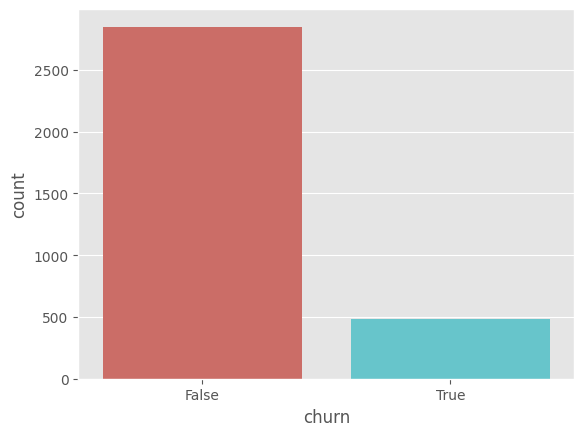

In [ ]:
print("Null values?: " + str(df.isnull().values.any()))
desc = df.describe()
sns.countplot(x='churn', data=df, palette='hls')

As the correlation plot and matrix show, we have some very large correlations between our predictors. However, we could expect these correlations as they are between minutes and charges. As one uses more minutes, their charges increase. Because of these large correlations, values of 1, we will drop the minutes related variables and keep charges. 

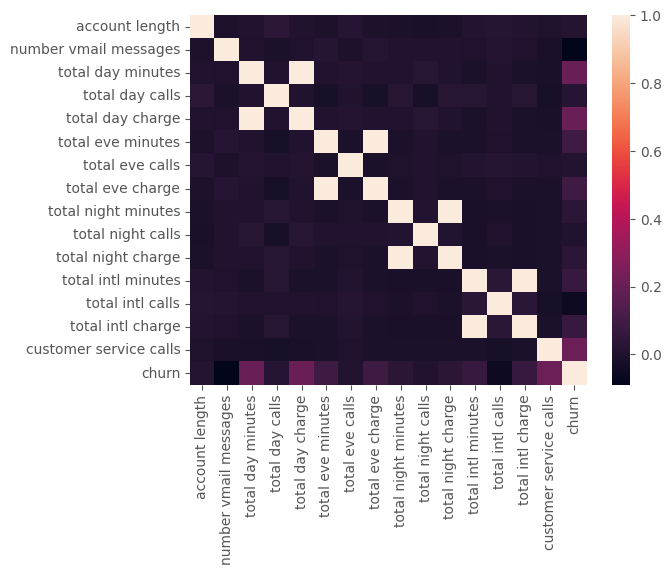

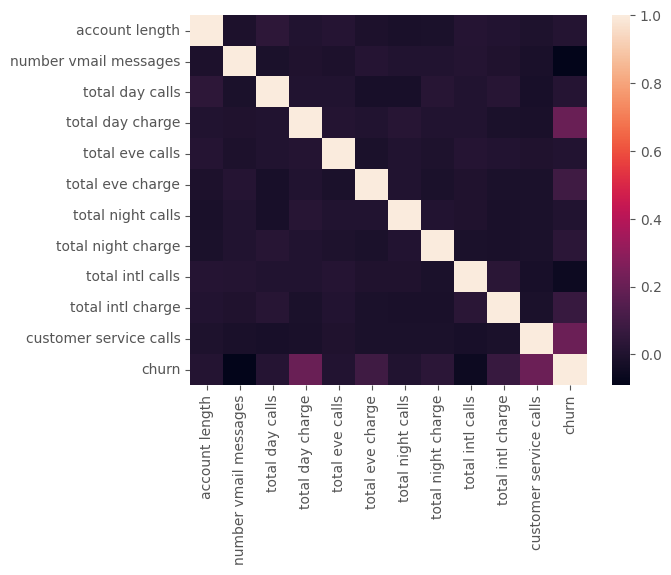

In [ ]:
df['churn'].value_counts() 

sns.heatmap(df.corr())
plt.show()
df.corr()
df = df.drop(columns = ['total day minutes', 'total eve minutes', 'total night minutes', 'total intl minutes'])
sns.heatmap(df.corr())
plt.show()

## - Count of Voicemail Plans & Non-Voicemail Plans

We found that when churn is false, the majority of customers had a voice mail plan, likely since a voice mail plan is pretty common. When churn is true, however, it is much more balanced.

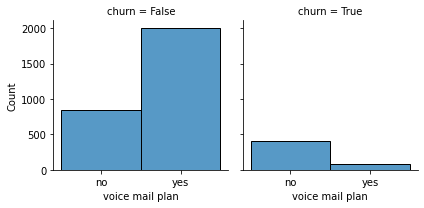

In [ ]:
g = sns.FacetGrid(df, col="churn")
g.map(sns.histplot, "voice mail plan")


## - Count of Internation & Domestic Plans

In comparing International Plan and churn, we can see that when churn is false, the majority of the plans are not international plans. When churn is true though, its much more balanced. This likely is because international plans are much less common than the standard, domestic plan. 

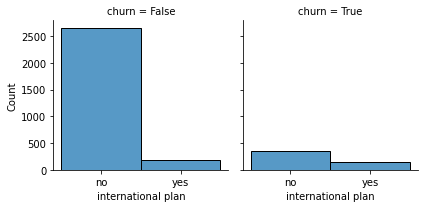

In [ ]:

k = sns.FacetGrid(df, col = 'churn')
k.map(sns.histplot, "international plan")


## - Account Length vs. Total Day Minutes 
The below plot shows the total day minutes plotted against account length, for international and domestic plans. The plots are separated again into churn = False and churn = True.

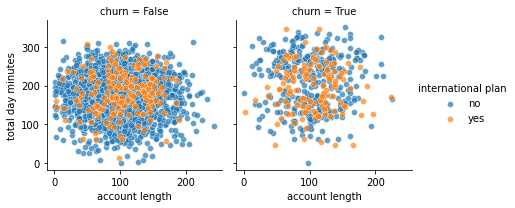

In [ ]:

l = sns.FacetGrid(df, col="churn", hue="international plan")
l.map(sns.scatterplot, "account length", "total day minutes", alpha=.7)
l.add_legend()


## - Total Day Minutes

In plotting a box plot of the Total Day Minutes, we found that when Churn = False, there are a number of outliers below about 50 minutes. 

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


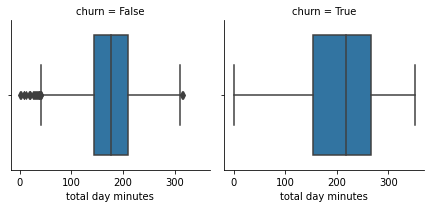

In [ ]:

n = sns.FacetGrid(df, col="churn")
n.map(sns.boxplot, "total day minutes")
n.add_legend()


## - Customer Service Calls
We plotted the distribution customer service calls for when churn = False and when churn = True. As you can see from the plot below, there are a good number of outliers when churn = False, and only one outlier when churn = True.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


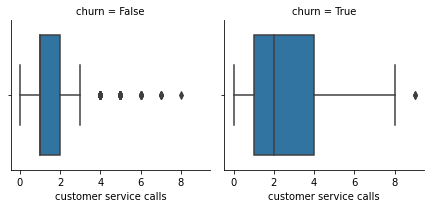

In [ ]:

o = sns.FacetGrid(df, col="churn")
o.map(sns.boxplot, "customer service calls")
o.add_legend()


From the below strip plot, we can see that churn does not seem to be related to the number of customer service calls. For both true and false, the number of customer service calls is fairly standard across the board. 

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


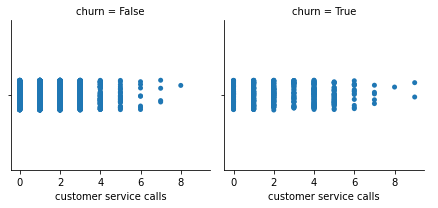

In [ ]:

#finish!
t = sns.FacetGrid(df, col="churn")
t.map(sns.stripplot, "customer service calls")
t.add_legend()


## - Distributions of Various Predictors

After plotting the distributions of various predictors, we found the following: 
1. Number of Voicemail Messages is not normally distributed. For the vast majority of the data, there were no 0 voicemail messages. However, for those that actually did receive voicemails, the distribution is mostly normal.  

2. Total Day/Eve/Night Calls are all normally distributed.

3. Total Day/Eve/Night Minutes are all normally distributed.

4. Total International Minutes is mostly normally distributed.

5. Total Internation Calls is not normally distributed, but skewed to the right.

6. Total Customer Service Calls is not normally distributed, but skewed to the right. 






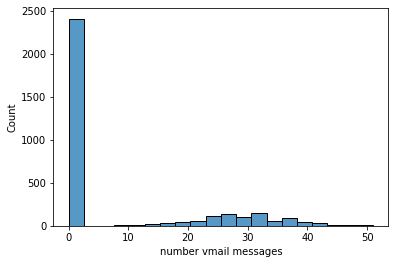

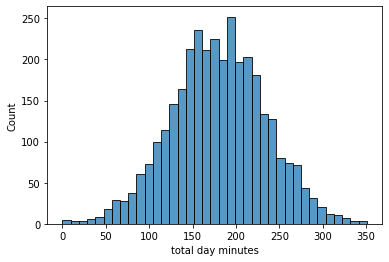

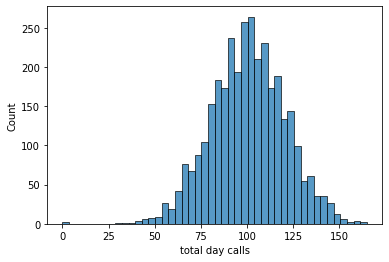

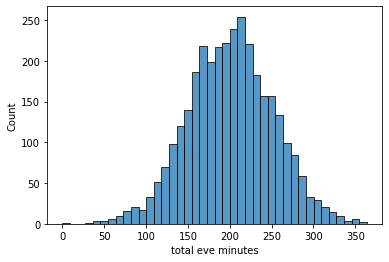

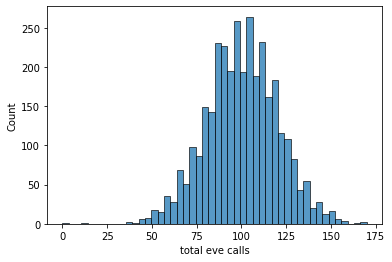

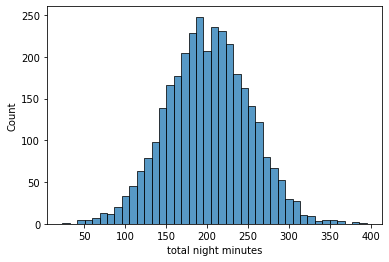

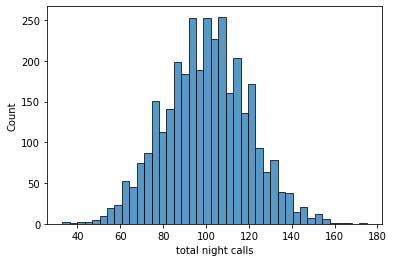

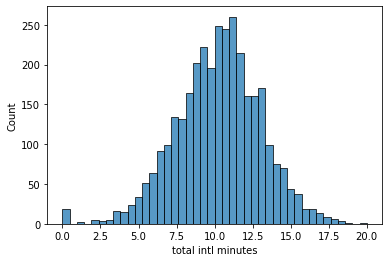

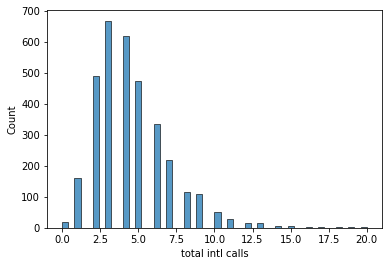

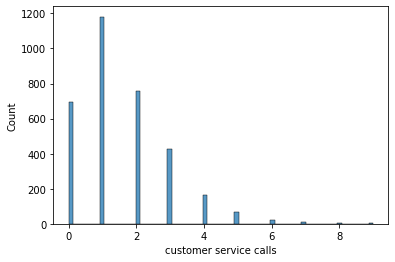

In [ ]:
sns.histplot(data = df, x = 'number vmail messages') # not normal
plt.show()

sns.histplot(data = df, x = 'total day minutes') # normal
plt.show()

sns.histplot(data = df, x = 'total day calls') # normal
plt.show()

sns.histplot(data = df, x = 'total eve minutes') # normal
plt.show()

sns.histplot(data = df, x = 'total eve calls') # normal
plt.show()

sns.histplot(data = df, x = 'total night minutes') # normal
plt.show()

sns.histplot(data = df, x = 'total night calls') # normal
plt.show()

sns.histplot(data = df, x = 'total intl minutes') # normal enough
plt.show()

sns.histplot(data = df, x = 'total intl calls') # not normal, right skew
plt.show()

sns.histplot(data = df, x = 'customer service calls') # not normal, right skew
plt.show()


---
# Naive Linear Regression Model
For our first model we developed, we tried just a simple, naive Linear Regression Model. We found the predictor most highly correlated with Churn, and used that to develop our simple model. We expected this model to not be very accurate at all, considering that churn is categorical, and not quantitative. 

First we processed the data to just use the highest correlated predictor, "Customer Service Calls".

In [ ]:
slr_X2 = df.iloc[:,:-1] # predictor
slr_y2 = df.iloc[:,-1] # response
slr_X2 = slr_X2['customer service calls'] # only keeping highest correlated pred
slr_X2 = slr_X2.values.reshape(-1,1) # reshaping for model requirements
slr_y2 = slr_y2.values.reshape(-1,1) # reshaping for model requirements


We then split our data into a training set and a testing set using a 70/30 split. 

In [ ]:

X_trainSLR, X_testSLR, y_trainSLR, y_testSLR = tts(slr_X2, slr_y2, 
                                                   test_size = .3, 
                                                   random_state = 11)

With our training and testing set ready, we then generated the Linear Regression Model. 

In [ ]:
# fitting model
model = LinearRegression().fit(X_trainSLR, y_trainSLR)

response = model.predict(X_testSLR) # predictions
r2 = model.score(X_trainSLR, y_trainSLR) # .score() regression default is r2

We then plotted our linear regression model.

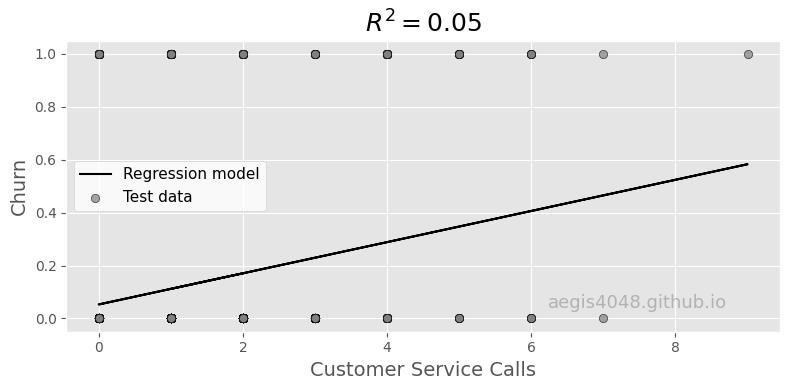

In [ ]:
plt.style.use('default')
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(X_testSLR, response, color='k', label='Regression model')
ax.scatter(X_testSLR, y_testSLR, edgecolor='k', facecolor='grey', alpha=0.7,
           label='Test data')

ax.set_ylabel('Churn', fontsize=14)
ax.set_xlabel('Customer Service Calls', fontsize=14)
ax.text(0.8, 0.1, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
         transform=ax.transAxes, color='grey', alpha=0.5)
ax.legend(facecolor='white', fontsize=11)
ax.set_title('$R^2= %.2f$' % r2, fontsize=18)

fig.tight_layout() 


Conclusion: As you can easily see, the Simple Linear Regression Model is not appropriate for accurately predicting churn. The R^2 value is incredibly low, at only 0.05, no where near anything usable. The churn data is qualitative, and so is just yes or no. However, the Linear Regression Model is fit for quantitative data, and so gives predictions somehow between Yes and No. Clearly, we needed to develop a different model, one that would more accurately predict customer churn. 

---
# Data Preprocessing
Unlike for a Simple Linear Regression, our next models required some preprocessing of the data. The following code was used to preprocess the data before creating our Logistic Regression Model.

First, we revert to the original data set so we can process the data to best fit the Logistic, Naive Bayes, and LDA models

In [ ]:
df = original

We then create dummy variables for the following categorical predictors: State, International, Voice-Mail, and Churn.

In [ ]:
stateDummy = pd.get_dummies(df['state'])
internationalDummy = pd.get_dummies(df['international plan'], 
                                    prefix = 'international')
voicemailDummy = pd.get_dummies(df['voice mail plan'], prefix = 'voicemail')
churnDummy = pd.get_dummies(df['churn'], prefix = 'churn')

We then merge these newly created dummy variables into our data set. 

In [ ]:
df = df.merge(stateDummy, how = 'left', left_index = True, right_index = True)
df = df.merge(internationalDummy, how = 'left', left_index = True, 
              right_index = True)
df = df.merge(voicemailDummy, how = 'left', left_index = True, 
              right_index = True)
df = df.merge(churnDummy, how = 'left', left_index = True, right_index = True)

Now that we have the dummy variables, we need to remove those categorical predictors from our data set. 
We also remove any other predictors deemed irrelevant, such as phone number and area code.

In [ ]:
df = df.drop(columns = ['state', 'international plan', 'voice mail plan', 
                        'area code', 'phone number', 'churn', 'churn_False',
                        'international_no', 'voicemail_no'])



We then total the minutes, charges, and calls. Since each of these predictors are spread out among "day", "night", and "eve", we want to consolidate them into Total _Minutes, Total_Charges, and Total_Calls. After doing so, we drop the day/night/eve predictors from our data. 

In [ ]:
totalCharge = df['total day charge'] + df['total night charge'] 
+ df['total eve charge']
totalCalls = df['total day calls'] + df['total eve calls'] 
+ df['total night calls']
df = df.drop(columns = ['total day charge', 
                        'total night charge', 'total eve charge', 
                        'total day calls', 'total eve calls', 
                        'total night calls'])
df['total charges'] = totalCharge


Organizing dataframe, splitting X (predictor) and Y (response)

In [ ]:

df = df[[c for c in df if c not in ['churn_True']] + ['churn_True']] # putting churn at end of matrix
df['churn_True'].astype('category') # setting churn as category, not sure if necessary
slr_X = df.iloc[:,:-1] # predictor
slr_y = df.iloc[:,-1] # response
# slr_X2 = slr_X['customer service calls'] # only keeping highest correlated pred
# slr_X2 = slr_X.values.reshape(-1,1) # reshaping for model requirements
# slr_y2 = slr_y.values.reshape(-1,1) # reshaping for model requirements

The data was split into our training and test sets. 70% of the randomly selected data was used for training, and the remaining 30% of the data was used for testing. We created two sets, one for the simple linear regression model with one predictor, and another for the other models. 

In [ ]:
X_train, X_test, y_train, y_test = tts(slr_X, slr_y, test_size=0.30, 
                                       random_state=11)


# X_trainSLR, X_testSLR, y_trainSLR, y_testSLR = tts(slr_X2, slr_y2, test_size = .3,
#                                                    random_state = 11)
# X_trainSLR, X_testSLR, y_trainSLR, y_testSLR = tts(slr_X, slr_y, test_size = .3,
#                                                    random_state = 11)

Now that we have removed irrelevant predictors, created dummy variables for categorical predictors, consolidated predictors with multiple subsets (day/night/eve), and split our data into training and test sets, we can now proceed with developing our models. 

---
# Logistic Regression Model

In [ ]:
# logistic regression

logmodel = LogisticRegression(max_iter = 10000, class_weight='balanced').fit(
    X_train, y_train)

We then used our Logistic Regression model to predict churn with our test data. After printing a classification report, we found that while precision was not the best for churnTrue, both churnTrue and churnFalse had relatively high recall values (precentage of correct positive predictions relative to total actual positives). The F1 score for churnFalse is fairly close to 1, but unfortunately churnTrue's F1 score is fairly low. It seems that our Logistic Regression Model is better at predicting when a customer does NOT churn. This makes sense due to our inbalanced dataset as our model could easily predict all as 'churnFalse' and still receive an accuracy of 84%.

In [ ]:
#define metrics
y_pred2 = logmodel.predict(X_test)
y_pred = logmodel.predict_proba(X_test)[::,1]
target_names = ['churnFalse', 'churnTrue']
print(classification_report(y_test, y_pred2, target_names=target_names))
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)

              precision    recall  f1-score   support

  churnFalse       0.95      0.78      0.85       856
   churnTrue       0.36      0.74      0.48       144

    accuracy                           0.77      1000
   macro avg       0.65      0.76      0.67      1000
weighted avg       0.86      0.77      0.80      1000



We then used a grid search to find the best hyperparameters for the logistic regression model. We considered a penalty option due to the number of variables after creating dummy variables and then lower values of C for the same reason. This way, we could tune our model and get a nice ROC curve. After tuning these hyperparameters, we found it also had an accuracy of about 0.76. We did see a lower precision when it came to predicting 'churnTrue'. Overall, we did not see significant improvement when tuning these hyperparameters.

In [ ]:
# grid search for best parameters
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg_cv=GridSearchCV(logmodel,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

logmodel2 = LogisticRegression(C = .1, penalty = 'l2', max_iter = 10000, 
                               class_weight='balanced').fit(X_train, y_train)

#define metrics
y_pred3 = logmodel2.predict(X_test)
y_pred4 = logmodel2.predict_proba(X_test)[::,1]
target_names = ['churnFalse', 'churnTrue']
print(classification_report(y_test, y_pred3, target_names=target_names))
fpr2, tpr2, _ = roc_curve(y_test,  y_pred4)
auc2 = roc_auc_score(y_test, y_pred4)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2'}
accuracy : 0.7599647848574886
              precision    recall  f1-score   support

  churnFalse       0.95      0.77      0.85       856
   churnTrue       0.35      0.74      0.47       144

    accuracy                           0.76      1000
   macro avg       0.65      0.75      0.66      1000
weighted avg       0.86      0.76      0.79      1000



Finally, we investigated feature selection with the logistic regression model. Using 'SelectKBest', we examine the strength of the relationship between each feature and the predictor and choose the 3 best. Results show that 'number vmail messages', 'total minutes', and 'total charges' are the 3 most important predictors. RFE is recursive feature elimination and removes features based on model performance after each iteration. Even with our feature selection choices, we still do not see any notable differences between models. 

In [ ]:
def featureSelection(x, y, k):
    select = SelectKBest(score_func = chi2, k = k)
    z = select.fit(x, y)
    b = select.fit_transform(x,y)
    cols = z.get_support(indices = True)
    return(cols,b)

cols, X_trainK = featureSelection(X_train, y_train, 3) # choosing 5 best hyperparameters
print(X_train.columns[cols])
rfe_selector = RFE(estimator=LogisticRegression(max_iter = 10000),
                   n_features_to_select = 3, step = 1)
rfe_selector.fit(X_train, y_train)
X_train.columns[rfe_selector.get_support()]

logmodel3 = LogisticRegression(max_iter = 10000, class_weight='balanced').fit(
    X_trainK, y_train)
#define metrics
X_testK = X_test[['number vmail messages', 'international_yes', 'total charges']]
y_pred5 = logmodel3.predict(X_testK)
y_pred6 = logmodel3.predict_proba(X_testK)[::,1]
target_names = ['churnFalse', 'churnTrue']
print(classification_report(y_test, y_pred5, target_names=target_names))
fpr3, tpr3, _ = roc_curve(y_test,  y_pred6)
auc3 = roc_auc_score(y_test, y_pred6)

Index(['number vmail messages', 'international_yes', 'total charges'], dtype='object')
              precision    recall  f1-score   support

  churnFalse       0.94      0.78      0.85       856
   churnTrue       0.34      0.69      0.46       144

    accuracy                           0.77      1000
   macro avg       0.64      0.73      0.65      1000
weighted avg       0.85      0.77      0.79      1000



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Next, we will finally try and tackle the problem with the unbalanced data. In the logistic regression function we are able to set weights for our classes which puts more emphasis on that class. 

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Scoring for different class weights')

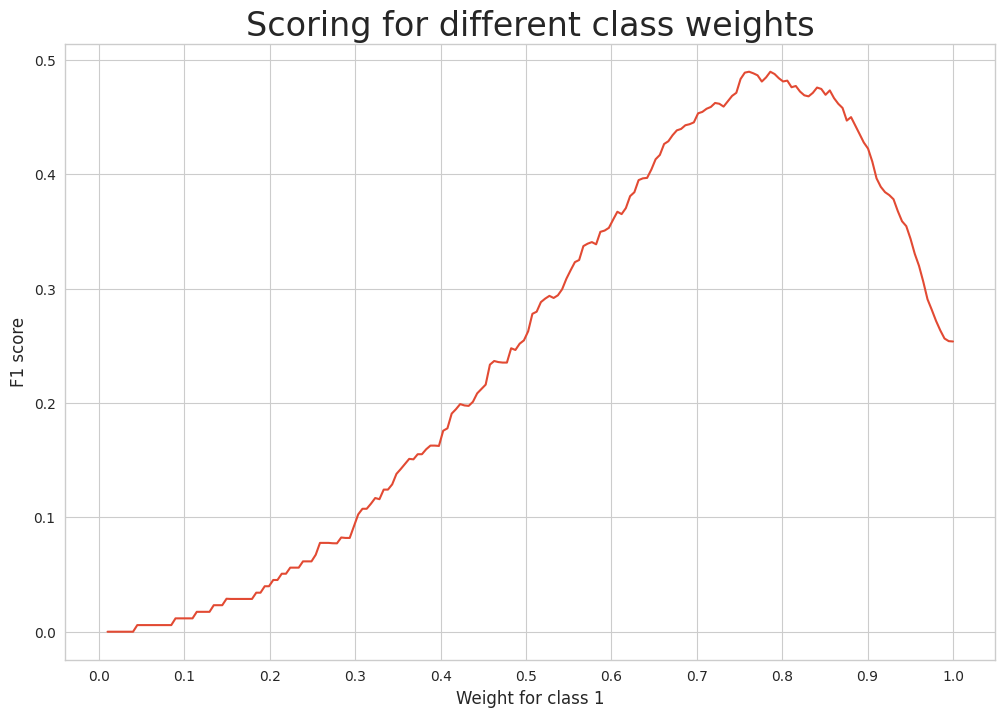

In [ ]:

lr = LogisticRegression(max_iter = 10000)

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('F1 scores by class weighhts', fontsize=24)

In [ ]:
print(weigh_data[weigh_data.score == weigh_data.score.max()])

       score    weight
48  0.489573  0.761206


Now that's an improvement! Model accuracy showing 83%. Probably should have started from here as we knew from the beginning that the classes were fairly inbalanced. 

In [ ]:
logmodel4 = LogisticRegression(max_iter = 10000, 
                               class_weight={0: 0.238794, 1: 0.761206}).fit(
                                   X_train, y_train)

#define metrics
y_pred7 = logmodel4.predict(X_test)
y_pred8 = logmodel4.predict_proba(X_test)[::,1]
target_names = ['churnFalse', 'churnTrue']
print(classification_report(y_test, y_pred7, target_names=target_names))
fpr4, tpr4, _ = roc_curve(y_test,  y_pred8)
auc4 = roc_auc_score(y_test, y_pred8)

              precision    recall  f1-score   support

  churnFalse       0.91      0.88      0.90       856
   churnTrue       0.41      0.51      0.46       144

    accuracy                           0.83      1000
   macro avg       0.66      0.69      0.68      1000
weighted avg       0.84      0.83      0.83      1000



## ROC Curve

After generating our logistic regression model, we then created an ROC curve to evaluate its performance. As you can see below, the ROC curve is pretty good, with an Area Under Curve fairly close to 1 (AUC = 0.81059). With this ROC curve, we can say that the logicistic regression model is an accurate model. Our logistic regression model also has a good trade-off between sensitivity and specificity.

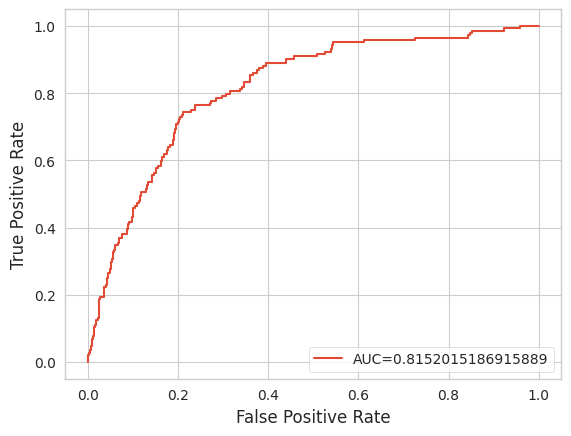

In [ ]:
#create ROC curve
plt.plot(fpr4,tpr4,label="AUC="+str(auc4))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

---
# Naive Bayes
Our next model we developed was a Naive Bayes Model. 

First, we revert to the original data set so we can process the data to best fit the Naive Bayes Model.

In [ ]:
df = original

For our first classification model, we developed a Naive Bayes model, assuming that all features are conditionally independent. 

In [ ]:
#------------------------------------------------------------------------------
def onehot(df, attribute):
  # Get one hot encoding of columns B
  one_hot = pd.get_dummies(df[attribute])

  # Drop column B as it is now encoded
  df = df.drop(attribute,axis = 1)

  # Join the encoded df
  df = df.join(one_hot)

  return df

df.sort_values(by=["churn"], inplace=True)

df["international plan"] = df["international plan"].replace(["no"], ["int'l plan-no"])
df["international plan"] = df["international plan"].replace(["yes"], ["int'l plan-yes"])

df["voice mail plan"] = df["voice mail plan"].replace(["no"], ["voice mail-no"])
df["voice mail plan"] = df["voice mail plan"].replace(["yes"], ["voice mail-yes"])

df = onehot(df, "state")
df = onehot(df, "international plan")
df = onehot(df, "voice mail plan")
df = onehot(df, "churn")

We use 30% of the data as the test data set and 70% of the data as the training dataset
74 x 3333 data, 72 features and 3333 instances

> We will have 1000 instances for the test set and 2333 instances for the training set <br>
<br> Base Data Set:
>> False: 2850 
<br> True: 483

> Test Set: <br> 
>>False: 855 
<br> True: 145

> Training Set: <br>
>>False: 1995 
<br>True 338 true <br>
 
The data frame is indexed from 0 to 3332.


In [ ]:
df1 = df.iloc[:855]
df2 = df.iloc[855:2850]
df3 = df.iloc[2850:2995]
df4 = df.iloc[2995:3332]

dftest = pd.merge(df1, df3, how = "outer")
dftrain = pd.merge(df2, df4, how = "outer")

We split the data into two data sets: the test and the training data sets. The test data set has 30% of instances, and the training set has 70% of them. Each has the same ratio of the classe.

In [ ]:
#drop state, internaional plan, voice mail plan, area code, phone number, churn, churn false
df_class = np.array([False, True])

We store the two classes of the data set in df_class.

In [ ]:
#Q(C = ci) = (number of instances in each class)/(number of instances in training sets)

def Q(df, attribute):
  value = 1.0
  occurence = df[attribute].value_counts()[value]
  return occurence / df.shape[0]

This function calculates the occurence of the class that the data point from the test set that we are handing in C() function. Then returns the ratio of class to the number of instance in the entire data set.

In [ ]:
#F (Aj = ak) = # {(xAj = ak) and (x = ci)} + 1/ Nci + d

def F(dftrain, attribute_name, attribute_value, class_name, len_class_name):
  sum_count = 0
  N = 0
  d = len(dftrain.columns) - len_class_name
  for k in dftrain.index:
    if ((dftrain[attribute_name][k] == attribute_value) and (dftrain[class_name][k] == 1)):
      sum_count = sum_count + 1
    if dftrain[class_name][k] == 1:
      N = N + 1

  numerator = sum_count + 1
  denominator = N + d
  F = numerator / denominator
  return F

This function will calculate the "sum_count" . sum_count is the number of cases when the two conditions are fulfiled: 1. the attribute value of the data point in the test set and the attribute value of the training are the same, and 2. the data point from the test set and the data point from the test set are in the same class. N is the number of cases when a data point in the test set and a data point in the training data set are in the same class. d is the number of attributes in the original data. The for loop goes through each data point in the training data set to calculate the sum_count and N between every point in the training data set and a data point in the test set. Here, we basically calculate the (sum_count + 1)/(N + d), which is the ratio of teh case when the data point from the test and the data point from the training set have the same attribute value and belong to the same class to the case when these two points are in the same class, and this function returns this value as "F" for each attribute in the data point in the test set that we handle in C() function.

In [ ]:
"""
this function will return the C function
"""
def C(instance, dftrain, class_name, len_class_name):
  Q_X = Q(dftrain, class_name)
  f = 1
  
  for index, value in instance.items():
    f = f * F(dftrain, index, value, class_name, len_class_name)

  return Q_X*f

This function goes through the attribute values in the data point from the test set, and calculates the product of the variable "f" and Q_X. This function returns the product of "f" times "Q_X" for each data point in the test set. Therefore, this calculates the product of "f" for each attribute in the data point from test set times the ratio of the class to which the data point belongs to. 

In [ ]:
"""
this function will iterate through the rows of the training dataset (instances in the training dataset),
and for each instance, this will iterate through the classes.
this function will call def C for each combination of the instance in the training dataset and the class

probably need two df, one for testing, one for training)

param {dftest: the dataset we use as the test dataset, this should be a pandas dataframe
       dftrain: the dataset we use as the training dataset, this should be a pandas dataframe
       class_name: an array of classes that is in the dataset we use, this must be np.array
}

return {C: the probability of a certain instance in a dataset belongs to a certain class in a dataset,
        we should have the return for each instance in the test dataset
        this return should be a number
}
"""

def Class(dftest, dftrain, class_name):
  matrix = []

  for X in range (dftest.shape[0]): #<- maybe we should change this to for index, value dftest.items():, we want the index of the rows in the dataset
    P = -1
    predict = None
    actual = None

    for g in class_name: #<- g is the actual class name in the class_name array
      if dftest.loc[X][g] == 1.0 or dftest.loc[X][g] == 1: #<- this like of code sees if the attribute under the class name in the X row is labeled as 1 or not
        actual = g

    for h in class_name: #<- h is the actual class name and for each row, this line of code drops the columns of the attribute with the class name
      dftest.loc[X].drop(h)
    
    for i in range(len(class_name)):
      C_X = C(dftest.loc[X], dftrain, class_name[i], len(class_name))
      if P < C_X:
        P = C_X
        predict = class_name[i]
    
    #print(predict, actual)
    matrix.append([predict, actual])
    print(X, actual, predict)
  
  return matrix

This code goes through each data point in the test set to calculate the probability of two classes given the attribute values. Then it returns the predicted class and the actual class for each data point from the test set as the variable "matrix". C() function is called for each data point in the test set to calculate the argmax of the predictions.

In [ ]:
matrix = Class(dftest, dftrain, df_class)

In [ ]:
def zero_loss_func(result):
  correct = 0
  incorrect = 0
  for i in range(len(result)):
    if result[i][0] == result[i][1]:
      correct = correct+1
    elif result[i][0] != result[i][1]:
      incorrect = incorrect + 1
  
  return [correct, incorrect]

The prediction accuracy was calculated using the 0-1 loss function. This function compares the predicted response and the actual response. The result shows that the Naive Bayes correctly predicted all the respones of data points in the test set.

In [ ]:
def confusion_matrix(result):
  false_false = 0
  false_true = 0
  true_false = 0
  true_true = 0

  #predict_actual
  
  for i in result:
    
    if (i[0] == i[1]):
      if (i[1] == False): #<- predict is 2 and actual is 2
        false_false += 1
      
      elif (i[1] == True): #<- predict is 2 and actual is 2
        true_true += 1

    elif (i[0] != i[1]):
      if (i[1] == False): #<- predict is 4 and actual is 2
        true_false += 1

      elif (i[1] == True): #<- predict is 2 and actual is 4
        false_true += 1
  
    matrix = [[false_false, false_true], [true_false, true_true]]
  return matrix

This function generates the confusion matrix for the prediction result based on the predicted response and the actual response. The confusion matrix also shows that the model correctly predicted the response values for all instances.

In [ ]:
zero_one = zero_loss_func(matrix)
confusionmatrix = confusion_matrix(matrix)

NameError: ignored